# Exercise - Iterative Phase Estimation
#### @Quantom  & @Micheal Healy & @Hoss Ajallooiean - Qiskit Slack
#### @taalexander & @mbhealy & @katetsu - Github

Join us on the Qiskit Slack channel [#ieee-tutorial-openqasm3](https://qiskit.slack.com/archives/C02HQLDS3D3)


Before trying to complete this notebook make sure you've completed the installation process as described in [Hello OpenQASM3](./Hello-OpenQASM3.ipynb).

The goal of this exercise is to understand how the Iterative Phase Estimation (IPE) algorithm works, why would we use the IPE algorithm instead of the QPE (Quantum Phase Estimation) algorithm and how to build it with Qiskit using the same circuit exploiting reset gate and the `c_if` method that allows to apply gates conditioned by the values stored in a classical register, resulting from previous measurements.

If you want a further background on iterative phase estimation have a look at the references below.

**References**

- [Section 2 of Lab 4: Iterative Phase Estimation (IPE) Algorithm](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm) 

- [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)
- [Arbitrary accuracy iterative phase estimation algorithm as a two qubit benchmark - arXiv:quant-ph/0610214
](https://arxiv.org/abs/quant-ph/0610214)

### Preamble

In [1]:
import os
from typing import Any, List, Dict, Union

import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute
from qiskit.tools.visualization import plot_histogram
from qiskit.result import marginal_counts
import qiskit.tools.jupyter

from run_openqasm3 import run_openqasm3

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

pi = np.pi

In [2]:
backend_sim = Aer.get_backend('aer_simulator')

hub = 'ibm-q-community'
group = 'ieee-session'
project = 'event-2021'
backend_name = 'ibm_perth'

IBMQ.load_account()
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend_real = provider.get_backend(backend_name)

basis_gates = backend_real.configuration().basis_gates

In [3]:
import qiskit.tools.jupyter
backend_real

<IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q-community', group='ieee-session', project='event-2021')>

In [4]:
from qiskit import qasm3

def dump_qasm3(circuit, backend=backend_real):
    return qasm3.Exporter(includes=[], basis_gates=basis_gates+["reset"], disable_constants=True).dumps(circuit)

## Conditined gates: the c_if method

Before starting the IPE algorithm, we will give a brief tutorial about the Qiskit conditional method, c_if, as it goes into building the IPE circuit.

`c_if` is a function (actually a method of the gate class) to perform conditioned operations based on the value stored previously in a classical register. With this feature you can apply gates after a measurement in the same circuit conditioned by the measurement outcome.

For example, the following code will execute the $X$ gate if the value of the classical register is $0$.

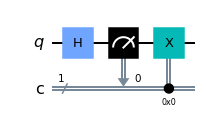

In [5]:
q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q, c)
qc.h(0)
qc.measure(0,0)
qc.x(0).c_if(c, 0)
qc.draw(output='mpl')

We highlight that the method c_if expects as the first argument a whole classical register, not a single classical bit (or a list of classical bits), and as the second argument a value in decimal representation (a non-negative integer), not the value of a single bit, 0, or 1 (or a list/string of binary digits).

Let's make another example. Consider that we want to perform a bit flip on the third qubit after the measurements in the following circuit, when the results of the measurement of $q_0$ and $q_1$ are both $1$.

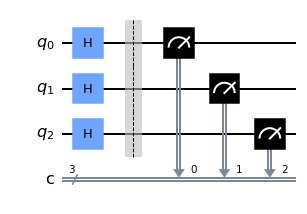

In [6]:
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
qc = QuantumCircuit(q, c)
qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.barrier()
qc.measure(q,c)
qc.draw('mpl')

We want to apply the $X$ gate, only if both the results of the measurement of $q_1$ and $q_2$ are $1$. We can do this using the c_if method, conditioning the application of $X$ depending on the value passed as argument to c_if.

We will have to encode the value to pass to the c_if method such that it will check the values 011 and 111 (in binary representation), since it does not matter what is in the rightmost position.

The 2 integer values in decimal representation:


<img src="figs/binary.png" width="50%" >


We can check the solutions using the bin() method in python (the prefix `0b` indicates the binary format).

In [7]:
print(bin(3))
print(bin(7))

0b11
0b111


So we have to apply $X$ to $q_2$ using c_if  two times, one for each value corresponding to 011 and 111.

*Note*: Conditioning on multiple bits is not supported just yet through IBM backends but it will be very soon.

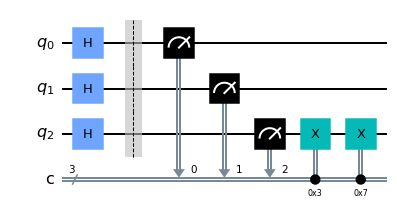

In [8]:
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
qc = QuantumCircuit(q, c)
qc.h(0)
qc.h(1)
qc.h(2)
qc.barrier()
qc.measure(q,c)

qc.x(2).c_if(c, 3) # for the 011 case
qc.x(2).c_if(c, 7) # for the 111 case

qc.draw(output='mpl')

## IPE

The motivation for using the IPE algorithm is that QPE algorithm works fine for short depth circuits but when the circuit starts to grow, it doesn't work properly due to gate noise and decoherence times.

The detailed explanation of how the algorithm works can be found in [Iterative Phase Estimation (IPE) Algorithm](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm). To understand QPE in depth, you can see also [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html).

### IPE example with a 1-qubit gate for $U$

We want to apply the IPE algorithm to estimate the phase for a 1-qubit operator $U$.  For example, here we use the $S$-gate.

Let's apply the IPE algorithm to estimate the phase for $S$-gate.
Its matrix is 
$$ S = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{2}\\ 
\end{bmatrix}$$

That is, the $S$-gate adds a phase $\pi/2$ to the state $|1\rangle$, leaving unchanged the phase of the state $|0\rangle$

$$ S|1\rangle = e^\frac{i\pi}{2}|1\rangle $$

In the following, we will use the notation and terms used in [Section 2 of lab 4](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm) of the Qiskit textbook.

Let's consider to estimate the phase $\phi=\frac{\pi}{2}$ for the eigenstate $|1\rangle$, we should find $\varphi=\frac{1}{4}$ (where $\phi = 2 \pi \varphi$). Therefore to estimate the phase we need exactly 2 phase bits, i.e. $m=2$, since $1/2^2=1/4$. So $\varphi=0.\varphi_1\varphi_2$.

Remember from the theory that for the IPE algorithm, $m$ is also the number of iterations, so we need only $2$ iterations or steps.

First, we initialize the circuit. IPE works with only 1 auxiliary qubit, instead of $m$ counting qubits of the QPE algorithm. Therefore, we need 2 qubits, 1 auxiliary qubit and 1 for the eigenstate of $U$-gate, and a classical register of 2 bits, for the phase bits $\varphi_1$, $\varphi_2$.

In [9]:
qubits = [5, 6]

### Exercise #1.A - Conditional Reset

Prepare the ground state for each of our qubits using three rounds of reset. 

First we'll do this with the conditional application of the $X$ gate based on a measurement. Use what you learned in the earlier presentation and about the `c_if` gate modifier to do this.

Keep in mind that if you implement comnditional reset yourself, you will have to add additional classical registers to the circuit to store the meaurement result in. You will then have to modify the analysis code later on to ignore those preparation results using `marginal_counts` function supplied by Qiskit.

In [10]:
def reset_conditional(qc, q, reset_reg):
    qc.barrier(q)
    qc.measure(q, reset_reg)
    qc.x(q).c_if(reset_reg, 1)
    qc.barrier(q)

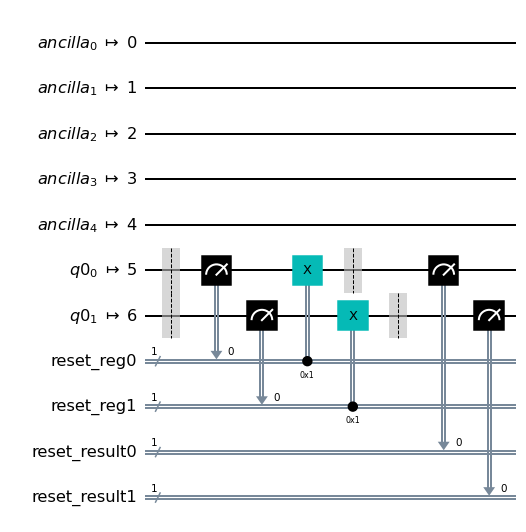

In [11]:
def reset_conditional(qc, q, reset_reg):
    qc.barrier(q)
    qc.measure(q, reset_reg)
    qc.x(q).c_if(reset_reg, 1)
    qc.barrier(q)

qr = QuantumRegister(2)
reset_reg0 = ClassicalRegister(1, "reset_reg0")
reset_reg1 = ClassicalRegister(1, "reset_reg1")
cr0 = ClassicalRegister(1, "reset_result0")
cr1 = ClassicalRegister(1, "reset_result1")

qc_reset = QuantumCircuit(qr, reset_reg0, reset_reg1, cr0, cr1)
reset_conditional(qc_reset, qr[0], reset_reg0)
reset_conditional(qc_reset, qr[1], reset_reg1)

qc_reset.measure(0, cr0)
qc_reset.measure(1, cr1)

qc_reset = transpile(qc_reset, backend_real, initial_layout=qubits)
qc_reset.draw(output="mpl")

In [12]:
# Hint use qiskit.result.marginal_counts to remove the first three classical register results
# from your counts
def pad_counts(counts):
    new_counts = {}
    for k, v in counts.items():
        if len(k) < 4:
            for _ in range(4-len(k)):
                k = "0"+k
        new_counts[k] = v
    return new_counts

def remove_reset_results(counts):
    return marginal_counts(pad_counts(counts), indices=[0, 1])



In [13]:
reset_job = run_openqasm3(qc_reset, backend_real, verbose=False)
print(f"Reset job id: {reset_job.job_id()}")
reset_result = reset_job.result()
reset_counts = remove_reset_results(reset_result.get_counts(0))
print(f"The results of your reset circuit are {reset_counts}")
assert reset_counts["00"] > 700

Reset job id: c6crc0u42htbamp4td7g
The results of your reset circuit are {'00': 976, '01': 12, '10': 12}


### Exercise #1.B - Qubit Initialization

To best initialize the qubit oftentimes multiple rounds of reset are required to drive the qubit as close as possible to the ground state which is determined by the readout errors, gate errors, and thermal populations of the system.

Below implement the `init` operation using three rounds of the builtin `QuantumCircuit.reset`, this handles the extra measurement bit required for you and is also more efficient in hardware.

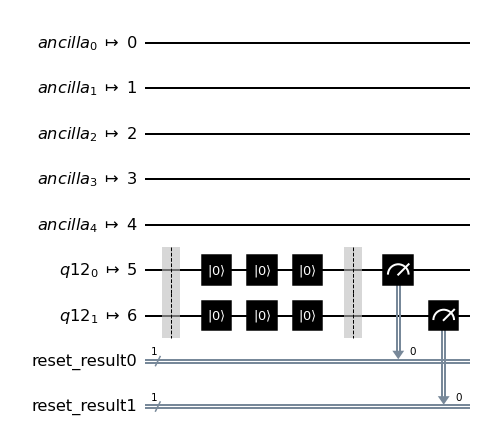

In [14]:
def init(qc, qr):
    """Implement a qubit initialization using three rounds of qubit reset."""
    qc.barrier(qr)
    qc.reset(qr)
    qc.reset(qr)
    qc.reset(qr)
    qc.barrier(qr)
    

    
qr = QuantumRegister(2)
cr0 = ClassicalRegister(1, "reset_result0")
cr1 = ClassicalRegister(1, "reset_result1")

qc_init = QuantumCircuit(qr, cr0, cr1)

init(qc_init, qr)

qc_init.measure(0, cr0)
qc_init.measure(1, cr1)

qc_init = transpile(qc_init, backend_real, initial_layout=qubits)
qc_init.draw(output="mpl")

In [15]:
init_job = run_openqasm3(qc_init, backend_real, verbose=False)
print(f"Qubit init job id: {init_job.job_id()}")
init_result = init_job.result()
init_counts = init_result.get_counts()
print(f"The results of your reset circuit are {init_counts}")
assert init_counts["0 0"] > 900

Qubit init job id: c6crcae42htbamp4tdmg
The results of your reset circuit are {'0 0': 989, '0 1': 4, '1 0': 7}


## Exercise #1.c - Compare your initialization results against your reset

Did you do better? Why might that be?

In [16]:
delta_counts = init_counts["0 0"] - reset_counts["00"]
print(f"With the initialization circuit we prepared the ground state {delta_counts} more times than in the reset circuit.""")

With the initialization circuit we prepared the ground state 13 more times than in the reset circuit.


## IPE - First step

Now we build the quantum circuit for the first step, that is, the first iteration of the algorithm, to estimate the least significant phase bit $\varphi_m$, in this case $\varphi_2$. For the first step we have 4 sub-steps:
- qubit initialization
- initialization
- application of the Controlled-$U$ gates
- measure of the auxiliary qubit in x-basis


In [17]:
nq = 2
m = 2

In [18]:
qr = QuantumRegister(2,'q')
c0 = ClassicalRegister(1,'c0')
c1 = ClassicalRegister(1, 'c1')
qc_S = QuantumCircuit(qr, c0, c1)

### Exercise 2. - Qubit Initialization

Before we begin using our qubits we must initialize them. Use the `init` function you wrote earlier to initialize the qubits in in qc_S below.

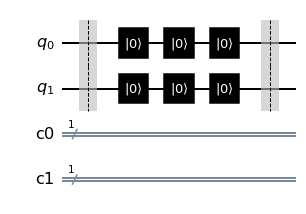

In [19]:
def init_ipe_circuit(qc):
    """Initialize the qubits in your IPE circuit."""
    init(qc, [0, 1])

init_ipe_circuit(qc_S)
qc_S.draw(output="mpl")

### Exercise 3. Eigenstate Initialization

The initialization consists of application the Hadamard gate to the auxiliary qubit and the preparation of the eigenstate $|1\rangle$. Complete this below by filling in the function.

**hint**: To prepare the $|1>$ state recall how we corrected for an inadverdent $|1>$ in our conditional qubit reset.

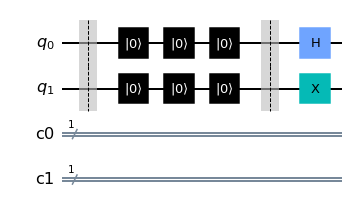

In [20]:
def initialize_eigenstate(qc):
    """Initialize the eigenstate and prepare our ancilla qubit"""
    qc.h(0)
    qc.x(1)

initialize_eigenstate(qc_S)
    
qc_S.draw('mpl')


#### Application of the Controlled-$U$ gates

Then we have to apply $2^t$ times the Controlled-$U$ operators (see also in the docs [Two qubit gates](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#Two-qubit-gates)), that, in this example, is the Controlled-$S$ gate ($CS$ for short).

To implement $CS$ in the circuit, since $S$ is a phase gate, we can use the controlled phase gate $\text{CP}(\theta)$, with $\theta=\pi/2$.

In [21]:
theta = 1 * np.pi / 2


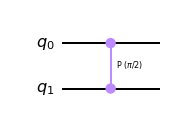

In [22]:
cu_circ = QuantumCircuit(2)
cu_circ.cp(theta,0,1)
cu_circ.draw('mpl')


Let's apply $2^t$ times $\text{CP}(\pi/2)$. Since for the first step $t=m-1$, and $m=2$, we have $2^t=2$.

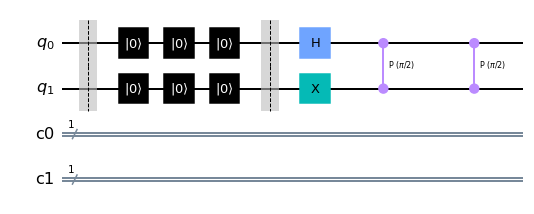

In [23]:
for _ in range(2**(m-1)):
    qc_S.cp(theta,0,1)
qc_S.draw('mpl')

## Exercise 5 - Measure in x-basis

Finally, we perform the measurenment of the auxiliary qubit in x-basis. Fill out the function to perform the x_measure and then apply it. 


In this way we obtain the phase bit $\varphi_2$ and store it in the classical bit $c_0$.

**hint**: The eigenvectors of the Hadamard gate are the basis vectors of the x-basis.

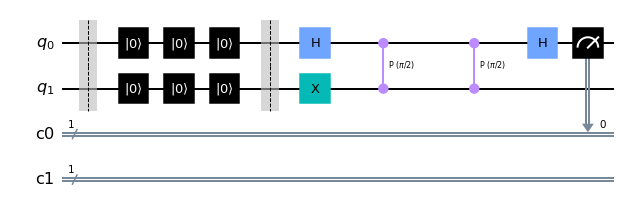

In [24]:
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)
    
x_measurement(qc_S, qr[0], c0)
qc_S.draw('mpl')


### Subsequent steps (2nd step)

Now we build the quantum circuit for the other remaining steps, in this example, only the second one.
In these steps we have 4 sub-steps: the 3 sub-steps as in the first step and, in the middle, the additional step of the phase correction
- initialization with reset
- phase correction
- application of the Control-$U$ gates
- measure of the auxiliary qubit in x-basis


## Exercise 6 - Reset the auxiliary qubit

As we want to perform an iterative algorithm in the same circuit, we need to reset the auxiliary qubit $q0$ after the measument gate and initialize it again as before to recycle the qubit. 

Use the builtin `qc.reset` operation to perform a reset of qubit 0 followed by the hadamard operation.

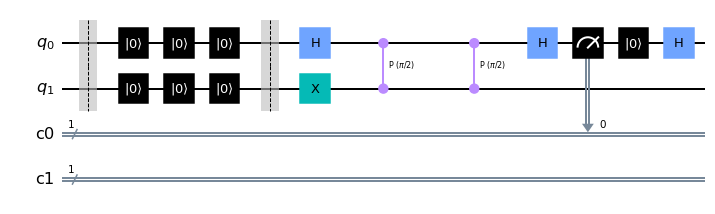

In [25]:
def reset_auxiliary(qc):
    qc.reset(0)
    qc.h(0)

reset_auxiliary(qc_S)
qc_S.draw('mpl')

#### Phase correction (for step 2)
As seen in the theory, in order to extract the phase bit $\varphi_{1}$, we perform a phase correction of $-\pi\varphi_2/2$.
Of course, we need to apply the phase correction in the circuit only if the phase bit $\varphi_2=1$, i.e. we have to apply the phase correction of $-\pi/2$ only if the classical bit $c_0$ is 1.

So, after the reset we apply the phase gate $P(\theta)$ with phase $\theta=-\pi/2$ conditioned by the classical bit $c_0$ ($=\varphi_2$) using the `c_if` method.
So as we saw in the first part of this tutorial, we have to use the `c_if` method with a value of 1, as $1_{10} = 001_{2}$ (the subscripts $_{10}$ and $_2$ indicate the decimal and binary representations).

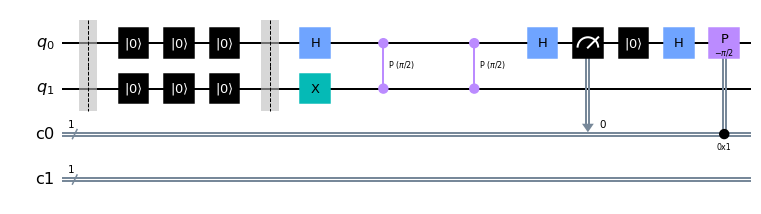

In [26]:
qc_S.p(-np.pi/2,0).c_if(c0, 1)
qc_S.draw('mpl')

#### Application of the Control-$U$ gates and x-measurement (for step 2)

We apply the $CU$ operations as we did in the first step. For the second step we have $t=m-2$, hence $2^t=1$. So we apply $\text{CP}(\pi/2)$ once. And then we perform the x-measurment of the qubit $q_0$, storing the result, the phase bit $\varphi_1$, in the bit $c_1$ of classical register.

In [27]:
## 2^t c-U operations (with t=m-2)
for _ in range(2**(m-2)):
    qc_S.cp(theta,0,1)

x_measurement(qc_S, qr[0], c1) 

Et voilà, we have our final circuit

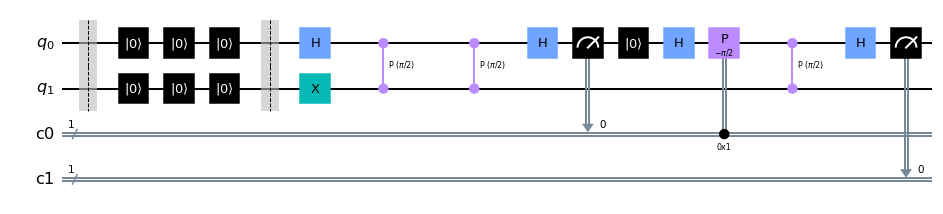

In [28]:
qc_S.draw('mpl')

Let's execute the circuit with the `qasm_simulator`, the simulator without noise that run locally.

In [29]:
count = execute(qc_S, backend_sim).result().get_counts()
count

{'0 1': 1024}

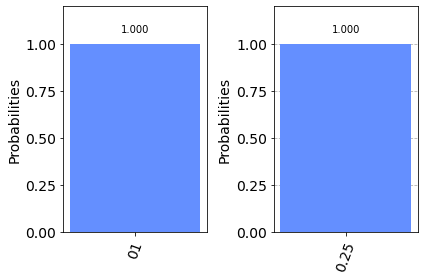

In [30]:
count0 = remove_reset_results(execute(qc_S, backend_sim).result().get_counts())

key_new = [str(int(key,2)/2**m) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
plt.tight_layout()

In the picture we have the same histograms but on the left we have on the x-axis the string with phase bits $\varphi_1$, $\varphi_2$ and on the right the actual phase $\varphi$ in decimal representation.

As we expected we have found $\varphi=\frac{1}{4}=0.25$ with a $100\%$ probability.

## Now lets run on real hardware

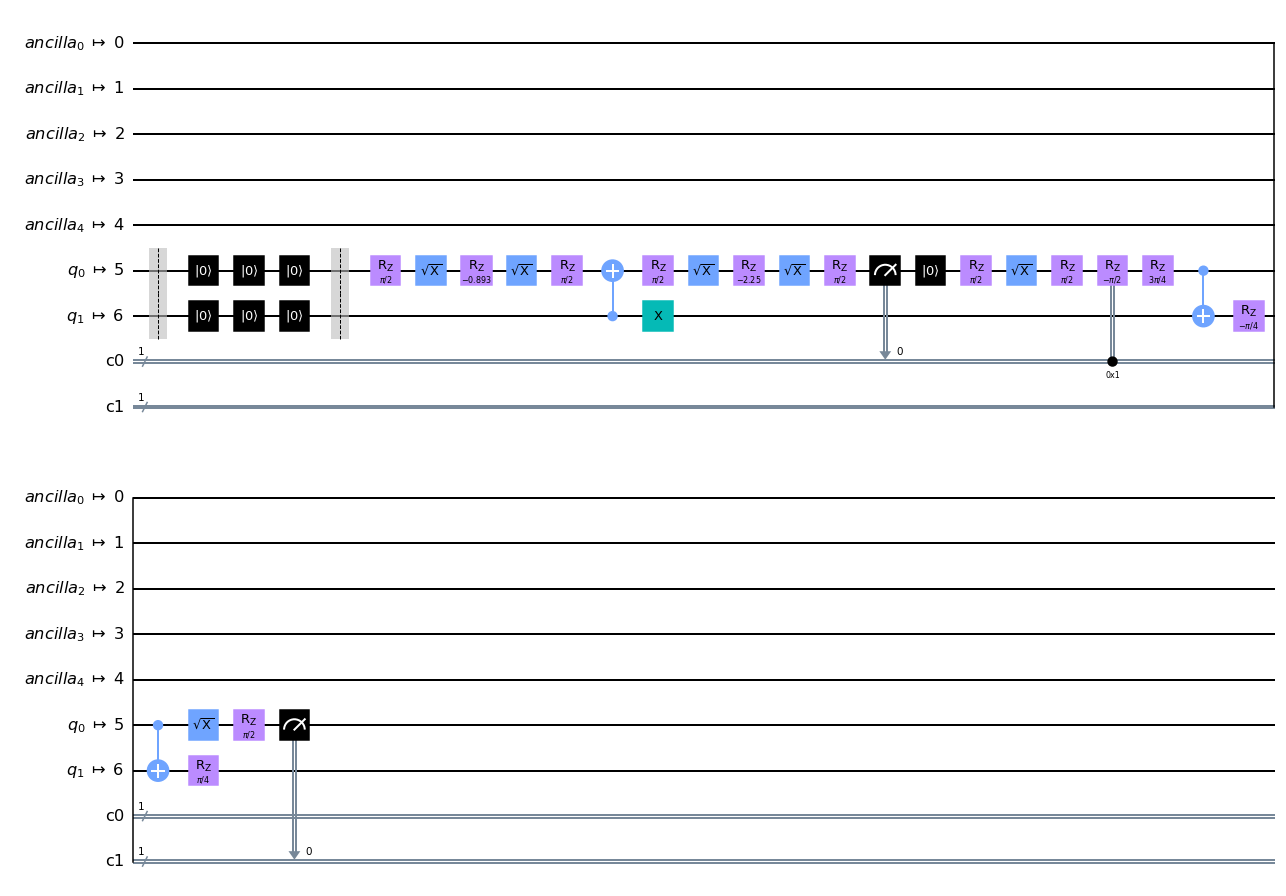

In [31]:
qc_S_backend = transpile(qc_S, backend_real, initial_layout=qubits, optimization_level=3)
qc_S_backend.draw(output="mpl")

In [32]:
real_ipe_job = run_openqasm3(qc_S_backend, backend_real, verbose=False)
print(f"IPE job id: {real_ipe_job.job_id()}")

IPE job id: c6crdvnalsooemjqei6g


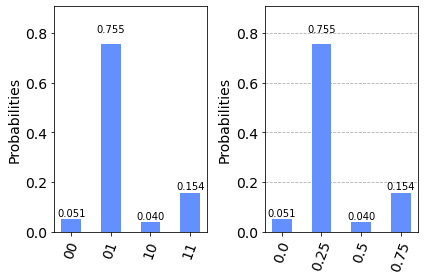

In [33]:
real_counts0 = remove_reset_results(real_ipe_job.result().get_counts())
real_key_new = [str(int(key,2)/2**m) for key in list(real_counts0.keys())]
real_counts1 = dict(zip(real_key_new, real_counts0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(real_counts0, ax=ax[0])
plot_histogram(real_counts1, ax=ax[1])
plt.tight_layout()

## Exercise 7 - Try estimating the phase of another Gate
Now that we have estimated the phase of the $S$ gate, lets try finding the phase of another gate. Lets this by using that fact that we implemented IPE for `S` using the $P(\theta)$ gate. Choose a new instance of the $P$ gate that can be estimated with two bits of precision and rerun.

Solution - Modify $\theta$ and rerun

## Exercise 8 (Stretch goal) - Adding an extra bit of precision
Now that we have mastered IPE for two bits of precision, lets try adding a third bit. Modify the code of this exercise to add another round of IPE.



In [34]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright